In [1]:
from netCDF4 import *
import matplotlib.pyplot as plt
import matplotlib.colors as co
import matplotlib.ticker as ticker
from path import Path
import pandas as pd
import xarray as xr
import numpy as np
import math
import scipy.interpolate as interp
import scipy.stats as stats
import tkinter as tk
import os

from matplotlib import rc
font = {"family": "serif", "weight": "normal", "size": 13}
rc("font", **font)
rc("text", usetex=True)



In [2]:
def get_imax(field_name = "fields",step = 1):
    i = 0
    while os.path.exists(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)):
        i += step
    return i-1

In [3]:
def EDS_fields(field_name = "fields",evolution = False,registerName = None,step = 1):
    """Converts a simulation output (series of velocity fields) into an energy density spectrum
    The result is register into a csv file for further analysis
    By default only the first and last fields are processedn unless evolution = True."""

    path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\\Work\\Github\\Simulation\\Submesoscale simulation\\Forcing\\"+field_name+"\\field0\\ux")
    with open(path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    data_lines = lines[1:]
    data = [list(map(float, line.split())) for line in data_lines]

    size = int(math.sqrt(len(data)))


    #Definition of the size of the grid
    nx = size
    ny = size

    #Cell size in meters
    dx = 5*110000/nx
    dy = 5*110000/ny

    # Wavenumber axes
    kx = np.fft.fftfreq(nx, d=dx)  
    ky = np.fft.fftfreq(ny, d=dy) 

    # Radial wavenumber grid
    kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
    k_mag = np.sqrt(kx_grid**2 + ky_grid**2)

    #Bins definition
    valid_k = k_mag > 0
    k_bins = np.logspace(np.log10(k_mag[valid_k].min()+0.1e-6)+1, np.log10(k_mag.max()), num=40)
    k_centers = (k_bins[:-1] * k_bins[1:])**0.5
   
    # Nyquist frequency mask
    nyq_mask = (k_centers <= 1/(dy*2))

    imax = get_imax(field_name,step)
    if evolution :
        rangei = range(0,imax,step)
    else :
        rangei = [10,imax]
        
    dict_df = {"characteristic_length": 1/k_centers[nyq_mask]}   

    #For each dataset
    for i in rangei:
        if os.path.exists(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)) :
            #import field
            
            path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)+"\\ux")
            with open(path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]

            data_lines = lines[1:]
            data = [list(map(float, line.split())) for line in data_lines]

            size = int(math.sqrt(len(data)))

            fieldx = np.zeros((size, size))

            for x in range(size):
                for y in range(size):
                    fieldx[x, y] = data[x * size + y][2]

            path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)+"\\uy")
            with open(path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]

            data_lines = lines[1:]
            data = [list(map(float, line.split())) for line in data_lines]

            size = int(math.sqrt(len(data)))

            fieldy = np.zeros((size, size))

            for x in range(size):
                for y in range(size):
                    fieldy[x, y] = data[x * size + y][2]

            # Select data
            u = np.array(fieldx)
            v = np.array(fieldy)

            # Compute kinetic energy field
            E_l = 0.5 * (np.abs(u)**2 + np.abs(v)**2)/(nx*ny)

            # Kinetic energy in Fourier space
            E_k = np.abs(np.fft.fft2(E_l))
            
            # Bin the energies   
            E_spectrum = np.zeros_like(k_centers)
            N_modes = np.zeros_like(k_centers)
                            

            for k in range(len(k_bins)-1):
                mask_bin = (k_mag >= k_bins[k]) & (k_mag < k_bins[k+1])
                # print(len(mask_bin),len(E_k))
                E_spectrum[k] = np.sum(E_k[mask_bin])
                N_modes[k] = np.sum(mask_bin)

            # Avoid division by zero (if a bin has no modes)
            valid_bins = N_modes > 0
            E_spectrum[valid_bins] /= N_modes[valid_bins]

            dict_df.update({str(i) : E_spectrum[nyq_mask]})

            
            reg = stats.linregress(np.log(1/(k_centers[nyq_mask])), np.log(E_spectrum[nyq_mask]))

            # Plot
            ax = plt.gca()
            if i == 10 :
                ax.plot(1/(k_centers[nyq_mask]), E_spectrum[nyq_mask], '-',label = 'First (slope = '+str(round(reg.slope,2))+')',c = ((i/len(rangei)/10),0,0))
            elif i == imax :
                ax.plot(1/(k_centers[nyq_mask]), E_spectrum[nyq_mask], '-',label = 'Last '+str(field_name)+'(slope = '+str(round(reg.slope,2))+')',c = ((i/len(rangei)/10),0,0))
            elif evolution :
                ax.plot(1/(k_centers[nyq_mask]), E_spectrum[nyq_mask], '-',c = ((i/len(rangei)/10),0,0))
            # ax.plot(1/(k_centers[nyq_mask]), 1e-9*1/k_centers[nyq_mask]**1.66 ,color = ('lightblue','blue','darkblue')[i])
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel('Characteristic length (m) ')
            ax.legend()
            ax.set_ylabel('Energy Density Spectrum')
            ax.grid(visible= True)

            df = pd.DataFrame(dict_df)
            df.to_csv(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\\Work\\Github\\Simulation\\Submesoscale simulation\\Forcing\\comparison_spectrum\\EDS_"+str(registerName)+".csv",index = False)
        else:
            print("field"+str(i)+" does not exist")

C:\Users\albou\AppData\Local\Temp\ipykernel_12268\2882160513.py:111: RuntimeWarning: divide by zero encountered in log
  reg = stats.linregress(np.log(1/(k_centers[nyq_mask])), np.log(E_spectrum[nyq_mask]))
C:\Users\albou\AppData\Local\Temp\ipykernel_12268\2882160513.py:123: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum

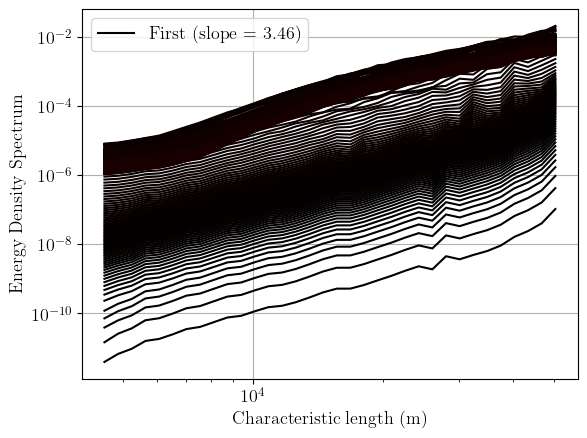

In [6]:
EDS_fields("Kolmog/K55km",True,registerName="K55km") 
